In [79]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [80]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
from torch.utils.data import sampler
import pickle
from google.colab import files

import torchvision.transforms as transforms
import pandas as pd
from pandas.core.frame import DataFrame
import tensorflow as tf
%matplotlib inline

In [81]:
val_ds_size = 12000
batch_size = 64
input_size = 3072
learning_rate = 0.0001
num_classes = 10 # digits can have one of ten values (for zero we use 10): (10, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [82]:
dataset = SVHN(root='data/', download=True, transform=ToTensor())

Using downloaded and verified file: data/train_32x32.mat


In [83]:
train_size = len(dataset) - val_ds_size

train_ds, val_ds = random_split(dataset, [train_size, val_ds_size])
print("trainset dataset size: " + str(len(train_ds)) + "\nvalidation dataset size: " + str(len(val_ds)))

trainset dataset size: 61257
validation dataset size: 12000


In [84]:
def hist_disb_of_digits(labels):
  plt.hist(labels)
  plt.show() 

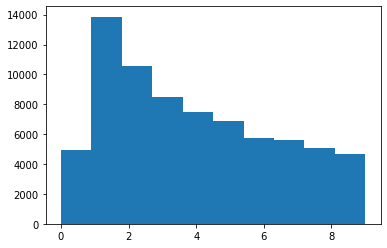

In [85]:
hist_disb_of_digits(train_ds.dataset.labels)

In [86]:
# def get_array_of_only_digit(digit, array):
#   df = pd.DataFrame(array.tolist(), columns=['digits'])
#   return df.query('digits == ' + str(digit))

# def normalize_dataset(dataset):
#   dfs = []

#   # all digits into seperate dataframes
#   for digit in range(num_classes):
#     array = get_array_of_only_digit(digit, dataset.dataset.labels)
#     dfs.append(array)

#   # get least amount of digits
#   min_amount = len(dfs[0])
#   for df in dfs:
#     min_amount = len(df) if len(df) < min_amount else min_amount

#   # make all digits same amount
#   for i, df in enumerate(dfs):
#     dfs[i] = df.sample(min_amount)

#   labels_result_df = pd.concat(dfs)

#   #take only data that coresponds to labels that werent removed
#   data_result = []
#   for i, label in labels_result_df.iterrows():
#     data_result.append(dataset.dataset.data[i])

#   data = torch.tensor(data_result)
#   labels = torch.tensor(labels_result_df.sort_index().to_numpy().flatten())
#   dataset = torch.cat((data, labels))

#   dataset.dataset.labels = labels_result_df.sort_index().to_numpy().flatten()
#   dataset.dataset.data = np.array(data_result)

#   return dataset

# # train_ds = normalize_dataset(train_ds)

In [87]:
def get_dataset_labels(dataset):
  return [i[1] for i in dataset]

def make_weights_for_balanced_classes(labels, nclasses):
  count = [0] * nclasses
  result = [0.] * nclasses

  for item in labels:      
    count[item] += 1   

  class_weights = [sum(count)/count[i] for i in range(len(count))]
  result = [class_weights[labels[i]] for i in range(int(sum(count)))]

  return result

def  get_weighted_random_sampler(dataset):
  labels = get_dataset_labels(dataset)

  weights = make_weights_for_balanced_classes(labels, num_classes)                                                                
  weights = torch.DoubleTensor(weights)   
  return torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

train_sampler = get_weighted_random_sampler(train_ds)
val_sampler = get_weighted_random_sampler(val_ds)

In [88]:
train_loader = DataLoader(train_ds, batch_size, num_workers=4, pin_memory=True, sampler=train_sampler)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True, sampler=val_sampler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [95]:
import time

def test_time_for_loaders(loader1):
  start_time = time.perf_counter()
  for i, (images, labels) in enumerate(loader1):
    pass
  end_time = time.perf_counter()

  time_passed = end_time - start_time
  return time_passed

for i in range(1, 5):
  loader = DataLoader(train_ds, batch_size, num_workers=i, pin_memory=True, sampler=train_sampler)
  time_passed = test_time_for_loaders(loader)
  print("num_workers=" + str(i) + " : " + str(time_passed) + "s")

num_workers=1 : 14.028013095999995s
num_workers=2 : 12.047000152999772s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


num_workers=3 : 11.189273565999883s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


num_workers=4 : 11.727882317999956s


In [ ]:
def get_digits_disb_in_loader(loader):
  lbs = [0] * 10
  for data, labels in loader:
    for digit in labels:
      lbs[digit] += 1
  return lbs

def get_all_digits_in_loader(loader):
  result = []
  for data, labels in loader:
    for digit in labels:
      result.append(int(digit))
  return result

labels_after_balancing = get_all_digits_in_loader(train_loader)
hist_disb_of_digits(labels_after_balancing)

In [ ]:
def plot_show_images_with_labels(images, labels):  
  fig, axes = plt.subplots(len(images), 1, figsize=(16, 4*len(images)))
  for i, ax in enumerate(axes.flat):
    transform = transforms.ToPILImage()
    img = transform(images[i])
    ax.imshow(img)
    ax.set_title(labels[i])   
    ax.set_xticks([]); ax.set_yticks([])
    if (i+1 == len(images)):
      break

for images, t in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    # plot_show_images_with_labels(images, t)

    break

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class SvhnModel(nn.Module):
    """Feedfoward neural network with 6 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 32)
        # output layer
        self.linear7 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)

        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)

        # Get predictions using output layer
        out = self.linear7(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
model = SvhnModel(input_size, out_size=num_classes)

In [ ]:
for t in model.parameters():
  print(t.shape)

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

In [ ]:
torch.cuda.is_available()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    # if (device != "cuda"):
    #     raise SystemExit
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
device = get_default_device()
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dataloader: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
val_loader = DeviceDataLoader(val_loader, device)
train_loader = DeviceDataLoader(train_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on CPU)
model = SvhnModel(input_size, out_size=num_classes)
to_device(model, device)

In [ ]:
#initial prediction accuracy without training
history = [evaluate(model, val_loader)]
history

In [ ]:
history += fit(250,learning_rate, model, train_loader, val_loader)

In [ ]:
# save and downlaod model
# pickle.dump(model, open('model.pkl', 'wb'))   #create model.pkl file wb - write in bytes
# files.download('model.pkl')